# Constants

In [1]:
IALAB_MEMBER = True
IALAB_USER = 'jiossandon'

# Imports

In [2]:
import os
import sys

In [3]:
if IALAB_MEMBER:
  matterport_build_path = f'/home/{IALAB_USER}/datasets/Matterport3DSimulator/build'
  metadata_script_path = f'/home/{IALAB_USER}/repos/360-visualization/metadata_parser'
else:
  matterport_build_path = f'/Matterport3DSimulator/build' # Path to simulator
  metadata_script_path = f'/360-visualization/metadata_parser' # Path to metadata parser of this repository

In [4]:
if matterport_build_path not in sys.path:
    sys.path.append(matterport_build_path)

if metadata_script_path not in sys.path:
    sys.path.append(metadata_script_path)

In [30]:
import json
import sys
import MatterSim
import time
import numpy as np
import skimage.transform
import networkx as nx

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from parse_house_segmentations import HouseSegmentationFile
from utils import load_nav_graph, compute_rel_heading, visualize_panorama_img, visualize_tunnel_img, get_viewpoint_region_name

# Metadata Parser

In [31]:
viewpoint = '28db29e8c72c4a68bfdf5bb2b454443d'
scan = '17DRP5sb8fy'

In [32]:
base_cache_path = f'/home/{IALAB_USER}/repos/360-visualization/metadata_parser/house_cache'
HouseSegmentationFile.base_cache_path = base_cache_path

In [33]:
metadata = HouseSegmentationFile.load_mapping(scan)

Cached file exists, loading.


In [34]:
objects = metadata.angle_relative_viewpoint_objects(viewpoint)
objects.head()

,object_index,region_index,category_index,px,py,pz,a0x,a0y,a0z,a1x,a1y,a1z,r0,r1,r2,category_mapping_name,distance,heading,elevation
0,64,3,0,-0.07887,0.184915,-0.499450,1,0,0,-0,0,1,1.2787,1.07518,1.07237,wall,0.201032,-0.403158,-1.188130
1,65,3,2,-0.02913,0.177214,0.469540,1,0,0,0,1,0,1.22366,1.06192,0.109429,ceiling,0.179592,-0.162921,1.205479
2,66,3,3,-0.20378,0.205052,-1.424073,1,0,0,0,1,0,1.14534,1.0373,0.15117,floor,0.289089,-0.782287,-1.370516
3,67,3,19,0.93712,0.642098,-0.061050,0,0,1,0,1,-0,0.56005,0.477925,0.0737991,mirror,1.135995,0.970085,-0.053690
4,68,3,1,-0.88530,0.344877,-0.533310,0,0,1,-0.92388,0.382683,0,1.02612,0.436492,0.113585,door,0.950103,-1.199323,-0.511491


In [35]:
connectivity_path = f'connectivity/{scan}_connectivity.json'

reachable_viewpoints = metadata.angle_relative_reachable_viewpoints(viewpoint, connectivity_path)
reachable_viewpoints

,distance,elevation,heading,name
0,1.490065,-0.807435,-1.023271,558ba0761bf24428b9cf91e60333ea25
1,0.704418,-1.144886,-0.256708,00ebbf3782c64d74aaf7dd39cd561175
2,0.634363,-1.184396,-2.484938,e693b5de8ad84d4cb61a79ece2e66d11


# Visualization

In [36]:
# Cylinder frame

RADIUS = 5

def data_for_cylinder_along_z(center_x, center_y, height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid = np.meshgrid(theta, z)
    
    x_grid = RADIUS * np.cos(theta_grid) + center_x
    y_grid = RADIUS * np.sin(theta_grid) + center_y
    return x_grid, y_grid, z_grid

In [38]:
# Panoramic image dimensions

IMG_HEIGHT = 1440
IMG_WIDTH = 2880

In [39]:
# Hide some objects

FORBIDDEN_WORDS = [
  'doorframe', 'light', 'floor', 'ceiling', 'remove', 'otherroom',
  'roof', 'unknown', 'wall', 'door', 'rug', 'frame', 'column', 'window', 
  'column', 'celing', 'door', 'picture', 'delete'
]

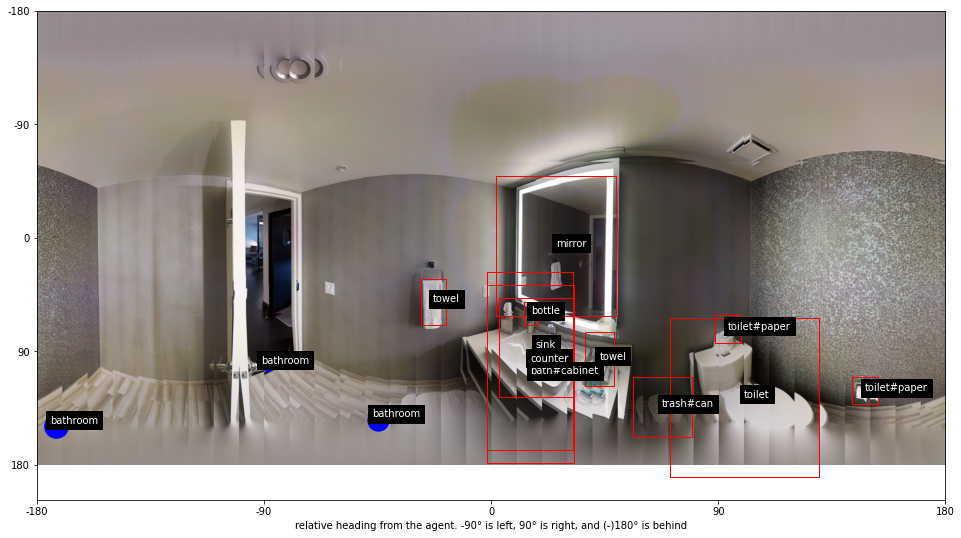

In [40]:
import matplotlib.patches as patches

plt.close('all')
viewpoint_heading = np.pi / 6

images = []
for viewpoint_elevation in (np.pi / 2 * x for x in range(-1, 2)):
    im = visualize_panorama_img(scan, viewpoint, viewpoint_heading, viewpoint_elevation)
    images.append(im)
    
_, ax = plt.subplots(1,1, figsize=(18,9))
img = np.concatenate(images[::-1], axis=0)

ax.imshow(img)
plt.xticks(np.linspace(0, IMG_WIDTH - 1, 5), [-180, -90, 0, 90, 180])
plt.xlabel(f'relative heading from the agent. -90° is left, 90° is right, and (-)180° is behind')
plt.yticks(np.linspace(0, IMG_HEIGHT - 1, 5), [-180, -90, 0, 90, 180])

x0, y0 = viewpoint_heading, 0
for obj in objects.itertuples():
    heading, elevation = float(obj.heading), float(obj.elevation)
    category = obj.category_mapping_name
    
    if any(word in category for word in FORBIDDEN_WORDS):
        continue

    heading -= x0
    while heading > np.pi:
        heading -= 2 * np.pi
    while heading < -np.pi:
        heading += 2 * np.pi

    elevation += y0
    while elevation > np.pi:
        heading -= 2 * np.pi
    while elevation < -np.pi:
        elevation += 2 * np.pi

    first_coord = (heading / (2 * np.pi) + 0.5) * IMG_WIDTH
    second_coord = (0.5 - elevation / (np.pi / 1.1)) * IMG_HEIGHT
    
    CONST = 300 * 1/obj.distance * 3
    
    first_pos = first_coord - float(obj.r1) * CONST / 2
    second_pos = second_coord - float(obj.r0) * CONST / 2
    rect = patches.Rectangle((first_pos, second_pos), float(obj.r1) * CONST, float(obj.r0) * CONST, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(first_coord, second_coord, f'{category}', color='white', backgroundcolor='black')

    
for reachable_viewpoint in reachable_viewpoints.itertuples():
    heading, elevation = float(reachable_viewpoint.heading), float(reachable_viewpoint.elevation)

    heading -= x0
    while heading > np.pi:
        heading -= 2 * np.pi
    while heading < -np.pi:
        heading += 2 * np.pi

    elevation += y0
    while elevation > np.pi:
        heading -= 2 * np.pi
    while elevation < -np.pi:
        elevation += 2 * np.pi

    first_coord = (heading / (2 * np.pi) + 0.5) * IMG_WIDTH
    second_coord = (0.5 - elevation / (np.pi / 1.1)) * IMG_HEIGHT
    
    region_name_of_viewpoint = get_viewpoint_region_name(metadata, reachable_viewpoint.name)
    
    ax.text(first_coord - 20, second_coord - 10, region_name_of_viewpoint, color='white', backgroundcolor='black')
    ax.plot(first_coord, second_coord, color='blue', marker='o', 
                     markersize= 15 / reachable_viewpoint.distance, linewidth=1)